In [1]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import experiments.parameters as parameters
from environments.observation_embeddings import CoordinateEmbedding, ObservationEmbedding


In [2]:
from core.mcts import MCTS, DistanceMCTS
from log_code.investigate_model import create_figure_and_axes, plot_value_network


challenge = parameters.env_challenges[2]

hparams = {**parameters.base_parameters, **challenge}
env = gym.make(**hparams["env_params"])
observation_embedding: ObservationEmbedding = CoordinateEmbedding(env.observation_space, hparams["ncols"] if "ncols" in hparams else 12)


agent = DistanceMCTS(
    embedding= observation_embedding,
    root_selection_policy=None,
    selection_policy=None,
    discount_factor=hparams["discount_factor"],
    )

rows, cols = observation_embedding.nrows, observation_embedding.ncols
goal_state = agent.goal_state
def value_from_obs(observation, discount_factor=hparams["discount_factor"]):


        """
        There are (rows-1) x cols + 1 possible states. The player cannot be at the cliff, nor at the goal as the latter results in the end of the episode. What remains are all the positions of the first 3 rows plus the bottom-left cell.
        The observation is a value representing the player’s current position as current_row * nrows + current_col (where both the row and col start at 0).
        For example, the stating position can be calculated as follows: (rows-1) * cols + 0 = 36.
        """
        goal_row = goal_state // cols
        goal_col = goal_state % cols
        current_row = observation // cols
        current_col = observation % cols

        col_diff = abs(goal_col - current_col)
        row_diff = abs(goal_row - current_row)
        manhattan_distance = col_diff + row_diff
        # special case for cliffwalking env
        # if we are in the last row, we need to add two since we cannot go directly to the goal (cuz cliff)
        if cols == 12:
            if current_row == rows - 1:
                manhattan_distance += 2
            return - float(manhattan_distance)
        else:
            return 1.0 * discount_factor ** manhattan_distance
def investigate_model():
    return {obs: value_from_obs(obs) for obs in range(observation_embedding.observation_space.n)}

output = investigate_model()
output

nrows: 4, ncols: 4


{0: 0.531441,
 1: 0.5904900000000001,
 2: 0.6561,
 3: 0.7290000000000001,
 4: 0.5904900000000001,
 5: 0.6561,
 6: 0.7290000000000001,
 7: 0.81,
 8: 0.6561,
 9: 0.7290000000000001,
 10: 0.81,
 11: 0.9,
 12: 0.7290000000000001,
 13: 0.81,
 14: 0.9,
 15: 1.0}

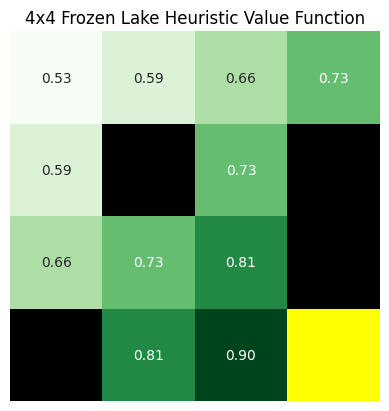

In [5]:

grid = np.zeros((rows, cols))
for state, value in output.items():
    row, col = divmod(state, cols)
    grid[row, col] = value
lake_map = [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
]
cliff_coords = [(r, c) for r, row in enumerate(lake_map) for c, char in enumerate(row) if char == 'H']
goal_coord = next((r, c) for r, row in enumerate(lake_map) for c, char in enumerate(row) if char == 'G')

nrows = grid.shape[0]
ncols = grid.shape[1]
# Cliff and goal state coordinates

# Set cliff and goal states to np.nan to hide their annotations
for (row, col) in cliff_coords:
    grid[row, col] = np.nan  # Remove numbers from the cliff cells
goal_row, goal_col = goal_coord
grid[goal_row, goal_col] = np.nan  # Remove numbers from the goal cell
# turn of axis labels
sns.heatmap(grid, annot=True, fmt=".2f", cbar=False, square=True, cmap="Greens", xticklabels=False, yticklabels=False)

for (row, col) in cliff_coords:
    plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=True, color='black', lw=0))

    # Highlight the goal state with yellow color
    plt.gca().add_patch(plt.Rectangle((goal_col, goal_row), 1, 1, fill=True, color='yellow', lw=0))
plt.title("4x4 Frozen Lake Heuristic Value Function")
plt.savefig(f"outfiles/lake_heuristic_value_function.pdf", bbox_inches='tight')
plt.show()